# Classification for Machine Learning

### Ideas:

#### Materials:
- CaMgO2 opt STO-3G
    - atoms only
    - whole cell
- CaSrO2 opt STO-3G

#### Energy
- run scf calculations on N structures
- train the NN using the descriptor neighbours_spatial_dist_all and the corresponding energy
- get the energy of new structures from the NN using their descriptor neighbours_spatial_dist_all

#### Geometry optimisation:
- optimise the geometry of N structures
- train the NN using the descriptor neighbours_spatial_dist_all and the displacement of the atoms in the structures. This would be a Mx3 (M = number of atoms) array that contains the x,y,z displacements.
- get the displacement of atoms for a new structure
- How do we include the cell? First line added to the neighbours_spatial_dist_all array of the structure (+ padding)?

#### Tests and questions
- How many shells to use?
- Using the non optimised energy vs using the optimised energy
- For the geometry optimisation part: does starting from a NN optimised structure make the full convergence quicker?
- Does training the NN with the optimised structure energies predict the energy of what the optimised geometry would give?
- Any difference in using fractional or cartesian displacements?

#### Info for the NN:
- neighbours_spatial_dist_all: descriptor for the structures (list of 2d arrays N_atoms x M_neighbours, where the M_neighbours depends on how many shells are included)
- energy: enegy of the optimised structures (list of J energy values, where J depends on how many calculations were performed)
- all_disp: information about the total displacement from the initial structures, cell and atoms (list of J 2d arrays (3 + N_atoms x 3), where J is the number of calculations that were run and the (3 + N_atoms are the cell parameters + the atom coordinates)
- disp_cell: information about the displacement from the initial cell (list of J 2d arrays (3 x 3), where J is the number of calculations that were run
- disp_atoms: information about the displacement of the atoms from the initial structures (list of J 2d arrays (N_atoms x 3), where J is the number of calculations that were run 

#### ML ideas:
- simple cosine similarity
- NN trained on 2D descriptors
- benchmark existing decriptors (https://singroup.github.io/dscribe/latest/tutorials/tutorials.html#)
- clustering vs regression
- geometry optimisation
- giving different weights to shells

#### Possible descriptors:
- neighbours_spatial_dist_all: descriptor for the structures (list of 2d arrays N_atoms x M_neighbours, where the M_neighbours depends on how many shells are included)
- neighbours_spatial_dist_all_sorted: like neighbours_spatial_dist_all, but storted row-sorted
- neighbours_spatial_dist_all_sorted_sliced: like neighbours_spatial_dist_all_sorted, but without the central atom number
- neighbours_spatial_dist_all_sorted_sliced_flat: like neighbours_spatial_dist_all_sorted, but without the central atom number, but as a flat array
- neighbours_spatial_dist_all_sorted_sliced_sum: like neighbours_spatial_dist_all_sorted_sliced, but summed columnwise


In [211]:
from crystal_functions.file_readwrite import Crystal_output, write_properties_input, Crystal_input, write_crystal_gui,write_crystal_input, Crystal_density
from crystal_functions.convert import cry_gui2pmg, cry_out2pmg
from crystal_functions.utils import view_pmg
from crystal_functions.calculate import cry_shrink

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.cif import CifWriter
from ase.visualize import view

from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core.surface import SlabGenerator
import numpy as np
import pandas as pd
import os
from pathlib import Path

from pymatgen.ext.matproj import MPRester
import json
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.cluster import KMeans

### Read the structures from the output files and replace with new_atom
This cell generates the structures list. This contains all the 4023 structures as pymatgen structure objects

In [88]:
'''with MPRester("p5vAQV3F1QuxFcxVT") as m:    
    cao = m.get_structure_by_material_id("mp-2605")'''

In [89]:
'''write_crystal_gui('data/classification/ml/cao.gui',cao)'''

In [212]:
cao = cry_gui2pmg('data/classification/ml/cao.gui')

In [213]:
new_atom = 'Mg'

cry_output = Crystal_output('data/classification/ml/cao_CONFCNT.out')

cry_output.get_config_analysis()

original_structure = cry_gui2pmg('data/classification/ml/cao_CONFCNT.gui')
structures = []
ca_atoms = []
mg_atoms = []
for j,substitutions in enumerate(cry_output.atom_type2):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures.append(new_structure)
    ca_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    mg_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())

### Shells

In [214]:
shells = np.unique(np.round(structures[0].distance_matrix[0],decimals=6),return_counts=True)[0].tolist()
shells

[0.0, 2.423808, 3.427782, 4.198159, 4.847616, 5.419799, 5.937093, 7.271424]

## Space group & Irreducible atoms

In [215]:
import sys
sys.path.insert(1,'../../crystal-code-tools/crystal_functions/crystal_functions/')
from calculate import cry_shrink
space_groups = []
n_irr_atoms = []
shrink = []
for i,structure in enumerate(structures):
    symm_analyzer = SpacegroupAnalyzer(structure)
    space_groups.append(symm_analyzer.get_space_group_number())
    symm_structure = symm_analyzer.get_symmetrized_structure()
    n_irr_atoms.append(len(symm_structure.equivalent_indices))
    shrink.append(cry_shrink(symm_analyzer.find_primitive(),spacing=0.2))
space_groups = np.array(space_groups)
#n_irr_atoms = np.array(n_irr_atoms)

In [97]:
space_groups_unique, space_groups_first, space_groups_count = np.unique(space_groups,return_counts=True, return_index=True)

In [98]:
space_groups_dict = {v: np.where(space_groups == v)[0] for v in np.unique(space_groups)}

# Analyse scf results

# The magic happens here

Each element of the neighbours_spatial_dist_all (one element per structure) is a 2D array whose rows correspond to an atom and the array contains:
- 0 = atom number of the atom whose neighbours I'm analysing
- 1:6 = atomic numbers of the atoms in the first coord shell
- 7:19 = atomic numbers of the atoms in the second coord shell
- 20:28 = atomic numbers of the atoms in the third coord shell

These atomic numbers are ordered following a spatial analysis. They are written starting from the atoms below the atom 0 and moving upwards.

## Spatial distribution analysis

In [104]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    if np.around(az,6) ==  np.around(2*np.pi,6) \
    or np.around(az,6) ==  -np.around(2*np.pi,6):
        az = 0.
    if np.around(az,6) < 0.:
        az = np.round(2*np.pi+az,6)
    return [round(az,6), round(el,6), round(r,6)]

## THIS ONE WORKS (it scales better when a small number of shells is included)

In [133]:
max_shell = 1
centered_sph_coords = []
centered_sph_coords_structure = []
neighbours_spatial_dist = []
neighbours_spatial_dist_all = []
import time
time0 = time.time()
#for k,structure in enumerate(structures[0:100]): #TMP only calculate 100 structures
for k,structure in enumerate(structures): 
    time0 = time.time()
    neighbours_spatial_dist = []
    
    for j in range(structure.num_sites):
        centered_sph_coords = []
        neighbours_spatial_dist_atom = []
        
        for n in range(max_shell+1):
            atom_indices = np.where(np.round(structure.distance_matrix[j],5) == np.round(shells[n],5))[0].tolist()
            centered_sph_coords = []
            for i in atom_indices:

                translation_vector = structure.sites[j].distance_and_image(structure.sites[i])[1]
                new_cart_coords = structure.cart_coords[i]+(translation_vector*structure.lattice.abc)
                centered_cart_coords = new_cart_coords-structure.cart_coords[j] 

                centered_sph_coords.append(cart2sph(centered_cart_coords[0],centered_cart_coords[1],centered_cart_coords[2]))        

            spatial_distribution = np.argsort(np.array(centered_sph_coords)[:,1]*10 +\
                                              np.array(centered_sph_coords)[:,0])


            neighbours_spatial_dist_atom.extend((np.array(structure.atomic_numbers)[np.array(atom_indices)[spatial_distribution]]).tolist())
        neighbours_spatial_dist.append(neighbours_spatial_dist_atom)
    #print(time.time()-time0)
    neighbours_spatial_dist_all.append(neighbours_spatial_dist) 
#neighbours_spatial_dist_all = np.array(neighbours_spatial_dist_all)        

In [134]:
neighbours_spatial_dist_all_json = json.dumps(neighbours_spatial_dist_all)
jsonFile = open('data/classification/ml/neighbours_spatial_dist_all_1.json', "w")
jsonFile.write(neighbours_spatial_dist_all_json)
jsonFile.close()

In [216]:
with open('data/classification/ml/neighbours_spatial_dist_all_1.json') as file:
    neighbours_spatial_dist_all = json.load(file)
neighbours_spatial_dist_all = np.array(neighbours_spatial_dist_all)

### Sort by first atom

In [217]:
neighbours_spatial_dist_all_sorted = []

for k,structure in enumerate(structures):
    sorted_atoms = []
    for i in range(len(neighbours_spatial_dist_all[0])):
        sorted_atoms.append(int(''.join([str(x) for x in neighbours_spatial_dist_all[k][i]])))
    neighbours_spatial_dist_all_sorted.append((np.array(neighbours_spatial_dist_all)[k][np.argsort(np.array(sorted_atoms))]).tolist())
neighbours_spatial_dist_all_sorted = np.array(neighbours_spatial_dist_all_sorted)    


In [227]:
neighbours_spatial_dist_all_sorted[0]

array([[12,  8,  8,  8,  8,  8,  8],
       [12,  8,  8,  8,  8,  8,  8],
       [12,  8,  8,  8,  8,  8,  8],
       [12,  8,  8,  8,  8,  8,  8],
       [12,  8,  8,  8,  8,  8,  8],
       [12,  8,  8,  8,  8,  8,  8],
       [12,  8,  8,  8,  8,  8,  8],
       [12,  8,  8,  8,  8,  8,  8],
       [12,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
       [20,  8,  8,  8,  8,  8,  8],
 

### Slice

In [218]:
neighbours_spatial_dist_all_sorted_sliced = neighbours_spatial_dist_all_sorted[:,:,1:]

### Flatten

In [219]:
neighbours_spatial_dist_all_sorted_sliced_flat = \
np.reshape(neighbours_spatial_dist_all_sorted_sliced, [4023,324])

In [228]:
neighbours_spatial_dist_all_sorted_sliced_flat[0]

array([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8, 12, 12, 12, 20, 20, 20, 12, 12,
       12, 20, 20, 20, 12, 12, 20, 20, 12, 20, 12, 12, 20, 20, 12, 20, 12,
       12, 20, 20, 12, 20, 12, 12, 20, 20, 12, 20, 12, 12, 20, 20, 12, 20,
       12, 12, 20, 20, 12, 20, 12, 20, 20, 12, 12, 20, 12, 20, 20, 12, 20,
       12, 20, 12, 12, 20

### Cosine similarity one by one

In [187]:
vector_descriptor = neighbours_spatial_dist_all_sorted_sliced_flat
a = vector_descriptor[0]
for i in range(len(neighbours_spatial_dist_all_sorted_sliced_flat)):   
    b = vector_descriptor[i]
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    print(cos_sim)

0.9999999999999999
0.9833072509128846
0.9822639540949399
0.9874804381846635
0.9780907668231611
0.9801773604590505
0.9822639540949399
0.9760041731872716
0.9791340636411058
0.9812206572769951
0.9760041731872716
0.9780907668231611
0.9770474700052164
0.9728742827334376
0.9760041731872716
0.9780907668231611
0.9728742827334376
0.9812206572769951
0.9749608763693269
0.9749608763693269
0.9780907668231611
0.9801773604590505
0.9801773604590505
0.9791340636411058
0.9780907668231611
0.9749608763693269
0.9728742827334376
0.9760041731872716
0.9739175795513823
0.9801773604590505
0.9780907668231611
0.9801773604590505
0.9760041731872716
0.9770474700052164
0.9718309859154929
0.9728742827334376
0.9822639540949399
0.9822639540949399
0.9760041731872716
0.9760041731872716
0.9801773604590505
0.9687010954616587
0.9770474700052164
0.9760041731872716
0.9697443922796034
0.9791340636411058
0.9770474700052164
0.9801773604590505
0.9739175795513823
0.9728742827334376
0.9822639540949399
0.9780907668231611
0.9739175795

0.9697443922796034
0.9697443922796034
0.967657798643714
0.9728742827334376
0.9666145018257694
0.9718309859154929
0.9739175795513823
0.967657798643714
0.9666145018257694
0.9687010954616587
0.9697443922796034
0.9707876890975481
0.9655712050078246
0.9707876890975481
0.9666145018257694
0.9666145018257694
0.9707876890975481
0.9645279081898799
0.9739175795513823
0.9666145018257694
0.9718309859154929
0.9728742827334376
0.9666145018257694
0.9707876890975481
0.9739175795513823
0.9687010954616587
0.9749608763693269
0.9697443922796034
0.9666145018257694
0.9666145018257694
0.9687010954616587
0.9697443922796034
0.9697443922796034
0.9718309859154929
0.9697443922796034
0.9697443922796034
0.9697443922796034
0.9728742827334376
0.9707876890975481
0.9707876890975481
0.9666145018257694
0.9728742827334376
0.9697443922796034
0.9697443922796034
0.967657798643714
0.9697443922796034
0.9707876890975481
0.9687010954616587
0.967657798643714
0.967657798643714
0.9655712050078246
0.9707876890975481
0.970787689097548

### Cosine similarity matrix

In [108]:
vector_descriptor = np.array(neighbours_spatial_dist_all_sorted_sliced_flat)[sort]
cos_sim_2d = []
n_elements = len(neighbours_spatial_dist_all_sorted_sliced_flat)


for i in range(n_elements):
    cos_sim_line = []
    a = vector_descriptor[i]
    for j in range(n_elements):
        b = vector_descriptor[j]
        cos_sim_line.append(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))
    cos_sim_2d.append(cos_sim_line)

In [109]:
np.array(cos_sim_2d)

array([[1.        , 0.98330725, 0.97704747, ..., 0.97704747, 0.98017736,
        0.97183099],
       [0.98330725, 1.        , 0.98017736, ..., 0.98017736, 0.97600417,
        0.97600417],
       [0.97704747, 0.98017736, 1.        , ..., 0.97913406, 0.98122066,
        0.98017736],
       ...,
       [0.97704747, 0.98017736, 0.97913406, ..., 1.        , 0.97809077,
        0.98226395],
       [0.98017736, 0.97600417, 0.98122066, ..., 0.97809077, 1.        ,
        0.97704747],
       [0.97183099, 0.97600417, 0.98017736, ..., 0.98226395, 0.97704747,
        1.        ]])

In [104]:
tst = []
for i in dist_std_first:
    tst.append(sort.tolist().index(i))

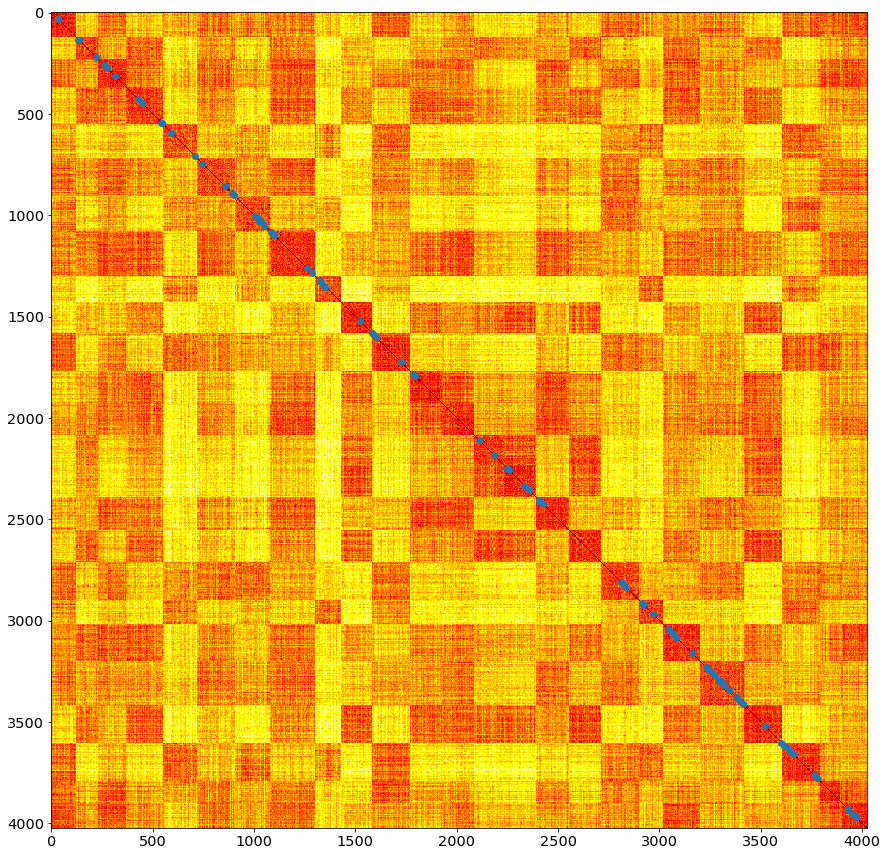

In [110]:
a = 1-np.array(cos_sim_2d)
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.scatter(tst,tst)
plt.show()

### k-Nearest Neighbour

In [231]:
X = neighbours_spatial_dist_all_sorted_sliced_flat
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
indices

array([[   0,    3,  125, ...,   36,    6,   95],
       [   1,    2,    3, ...,  451,  582,  299],
       [   2,    1,    3, ...,  101,  526,  696],
       ...,
       [4020, 3423, 1895, ..., 1861, 3255, 3179],
       [4021, 3746, 3846, ..., 3730, 2920, 1163],
       [4022, 3979, 3954, ..., 3859, 3924, 3784]])

#### Visualise

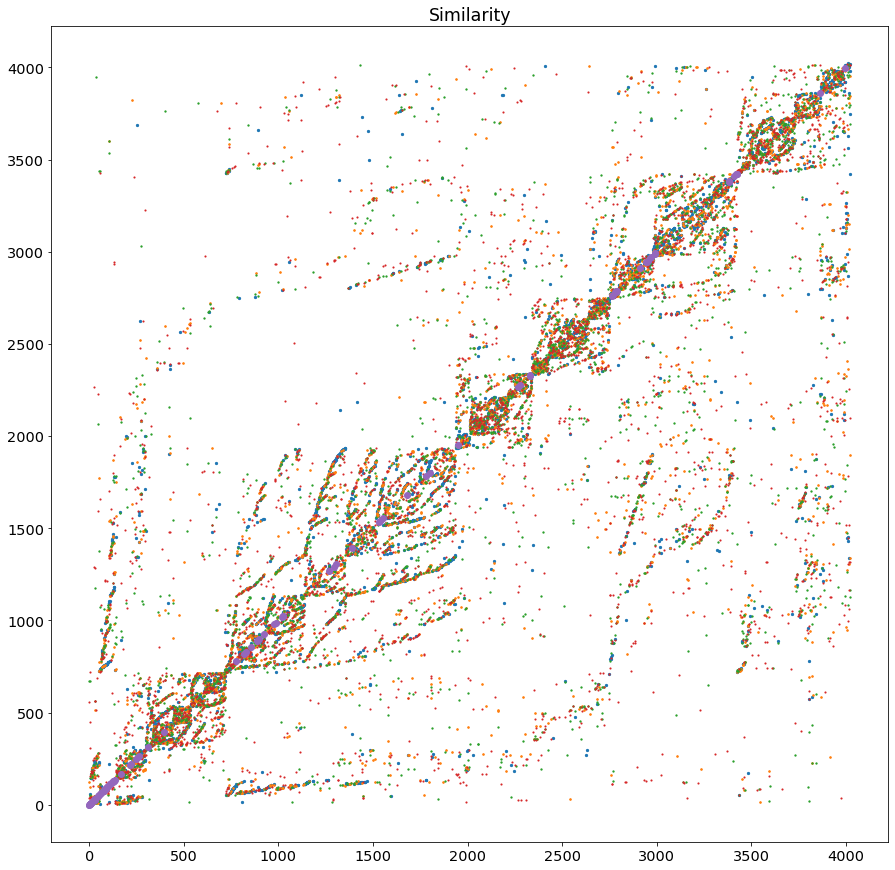

In [71]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

x = np.arange(4023)
for i in range(1,5):
    y = np.array(indices[:,i])

    plt.scatter(x, y, s=5*(1/i))
plt.scatter(dist_std_first,dist_std_first)
plt.title('Similarity')
plt.show()

#### Regressor

In [222]:
energies = np.random.random(4023)
y = energies
x = X

In [223]:
model = KNeighborsRegressor(n_neighbors=8)
model.fit(x,y)
pred_y = model.predict(x)
score=model.score(x,y)
print(score)

mse = mean_squared_error(y, pred_y)
print("Mean Squared Error:",mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


0.14705262546119524
Mean Squared Error: 0.07035682365916501
Root Mean Squared Error: 0.26524860727092425


### k-means

In [224]:
kmeans = KMeans(n_clusters=25, random_state=0).fit(X)

In [225]:
kmeans.labels_

array([13, 19, 19, ..., 12, 15, 20], dtype=int32)

In [226]:
sort = np.argsort(kmeans.labels_)

### Sum

In [177]:
neighbours_spatial_dist_all_sorted_sliced_sum = \
np.sum(neighbours_spatial_dist_all_sorted_sliced,axis=1)

## Neural networks

### Group same structures (none for LTS)

In [139]:
neighbours_spatial_dist_all_sorted = []
a = np.array(neighbours_spatial_dist_all[0])
a = neighbours_spatial_dist_all[0]

for k,structure in enumerate(structures[0:100]):
    sorted_atoms = []
    for i in range(len(neighbours_spatial_dist_all[0])):
        sorted_atoms.append(int(''.join([str(x) for x in neighbours_spatial_dist_all[k][i]])))
    neighbours_spatial_dist_all_sorted.append((np.array(neighbours_spatial_dist_all)[k][np.argsort(np.array(sorted_atoms))]).tolist())

In [12]:
neighbours_spatial_dist_id = []
a = np.array(neighbours_spatial_dist_all[0])
a = neighbours_spatial_dist_all[0]

for k,structure in enumerate(structures):
    sorted_atoms = []
    for i in range(len(neighbours_spatial_dist_all[0])):
        sorted_atoms.append((''.join([str(x) for x in neighbours_spatial_dist_all[k][i]])))
    neighbours_spatial_dist_id.append(int(''.join(sorted_atoms)))

IndexError: list index out of range

# Write inputs

## Selected structures

In [100]:
space_groups_dict

{1: array([   5,    6,    7, ..., 4010, 4011, 4012]),
 2: array([  15,   42,   48, 2084, 2130, 2161, 2181, 2194, 2328, 2337, 2671,
        2703, 2716, 2738, 2749, 3417]),
 5: array([  17,   41,   49,  152,  185,  305,  315,  318,  327,  341,  417,
         450,  502,  593,  734,  744,  757,  762,  768,  773,  778,  877,
         919,  950,  973, 1010, 1089, 1280, 1430, 1483, 1485, 1582, 1684,
        1689, 1705, 1751, 1808, 1901, 1962, 1972, 1989, 2006, 2029, 2055,
        2061, 2078, 2097, 2127, 2139, 2145, 2190, 2193, 2199, 2202, 2240,
        2265, 2270, 2298, 2306, 2327, 2336, 2344, 2485, 2509, 2510, 2567,
        2574, 2576, 2654, 2672, 2718, 2724, 2729, 2748, 2782, 2788, 2794,
        2805, 2807, 2830, 2835, 2849, 2851, 2855, 2862, 2866, 2934, 2947,
        2963, 2978, 2981, 3077, 3088, 3100, 3109, 3112, 3119, 3169, 3187,
        3211, 3212, 3246, 3247, 3257, 3270, 3276, 3286, 3296, 3299, 3321,
        3369, 3412, 3453, 3456, 3458, 3500, 3522, 3557, 3558, 3566, 3592,
        3616

In [103]:
crystal_input = Crystal_input('data/classification/ml/cao_crystal_input.d12')
with open('data/classification/ml/qsub_input.qsub','r') as file:
    qsub_input = file.readlines()

select_structures = [3862,5]    
for structure in select_structures:
    
    write_crystal_gui('data/classification/ml/cao_%s_PBE.gui'%structure,structures[structure])
    write_crystal_input('data/classification/ml/cao_%s_PBE.d12'%structure,crystal_input=crystal_input)
    queue = qsub_input.copy()
    queue[1] = '#PBS -N %s\n'%structure
    queue.append('/rds/general/user/gmallia/home/CRYSTAL17_cx1/v2.2gnu/runcryP cao_%s_PBE'%structure)
    with open('data/classification/ml/%s.qsub'%structure, 'w') as file:
        file.writelines(queue)
    #print('qsub %s.qsub'%structure)
    

## One per space group in reverse

In [ ]:
crystal_input = Crystal_input('data/classification/ml/pseudo_input.d12')
with open('data/classification/ml/qsub_input.qsub','r') as file:
    qsub_input = file.readlines()

    
for structure in reversed(np.unique(space_groups,return_counts=True, return_index=True)[1]):
    
    write_crystal_gui('data/classification/ml/pseudo/LTS_%s_PBE.gui'%structure,structures[structure],pseudo_atoms=[22])
    write_crystal_input('data/classification/ml/pseudo/LTS_%s_PBE.d12'%structure,crystal_input=crystal_input)
    queue = qsub_input.copy()
    queue[1] = '#PBS -N %s\n'%structure
    queue.append('/rds/general/user/gmallia/home/CRYSTAL17_cx1/v2.2gnu/runcryP LTS_%s_PBE'%structure)
    with open('data/classification/ml/pseudo/%s.qsub'%structure, 'w') as file:
        file.writelines(queue)
    #print('qsub %s.qsub'%structure)
    

## All space groups organised in folders

In [27]:
crystal_input = Crystal_input('data/classification/ml/crystal_input.d12')

with open('data/classification/ml/qsub_input.qsub_SAVE','r') as file:
    qsub_input = file.readlines()

for space_group in reversed(space_groups_unique[-12:]):
    #print(len(space_groups_dict[space_group]))
    queue = qsub_input.copy()
    queue[1] = '#PBS -N %s\n'%space_group

    Path('data/classification/ml/sg_%s'%space_group).mkdir(parents=True, exist_ok=True)
    for structures_n in space_groups_dict[space_group]:
        crystal_input.scf_block[0][1] = '%s %s \n'%(shrink[structures_n], shrink[structures_n]*2)
        write_crystal_gui('data/classification/ml/sg_%s/LTS_%s_PBE.gui'%(space_group,structures_n),structures[structures_n])
        write_crystal_input('data/classification/ml/sg_%s/LTS_%s_PBE.d12'%(space_group,structures_n),crystal_input=crystal_input)
        
        queue.append('/rds/general/user/gmallia/home/CRYSTAL17_cx1/v2.2gnu/runcryP LTS_%s_PBE\n'%structures_n)
    with open('data/classification/ml/sg_%s/sg_%s.qsub'%(space_group,space_group), 'w') as file:
        file.writelines(queue)
    print('cd sg_%s'%space_group)
    print('qsub sg_%s.qsub'%space_group)
    print('cd ..')

cd sg_225
qsub sg_225.qsub
cd ..
cd sg_166
qsub sg_166.qsub
cd ..
cd sg_164
qsub sg_164.qsub
cd ..
cd sg_160
qsub sg_160.qsub
cd ..
cd sg_155
qsub sg_155.qsub
cd ..
cd sg_151
qsub sg_151.qsub
cd ..
cd sg_146
qsub sg_146.qsub
cd ..
cd sg_139
qsub sg_139.qsub
cd ..
cd sg_121
qsub sg_121.qsub
cd ..
cd sg_119
qsub sg_119.qsub
cd ..
cd sg_107
qsub sg_107.qsub
cd ..
cd sg_82
qsub sg_82.qsub
cd ..


## Analyse the structures

In [15]:
import sys
sys.path.insert(1,'../../crystal-code-tools/crystal_functions/crystal_functions/')
from convert import cry_gui2pmg

initial_positions = structures[0].cart_coords
initial_cell = structures[0].lattice.matrix
structure_id = []
not_converged = []
energy = []
all_disp = []
output_folder = "data/classification/ml/outputs_optgeom/"
for file in os.listdir(output_folder):
    if file.endswith(".out"):
        structure_n = int(file.split('_')[1])
        output = Crystal_output(os.path.join(output_folder, file))
        if output.converged == True:
            structure_id.append(structure_n)
            #print(os.path.join("data/classification/ml/outputs_optgeom/", file[0:14]))

            energy.append(output.get_final_energy())
            last_geom = sorted(os.listdir(os.path.join(output_folder,"LTS_%s_PBE.optstory"%structure_n)))[-1]
            pmg_structure = cry_gui2pmg(os.path.join(output_folder,"LTS_%s_PBE.optstory/%s"%(structure_n,last_geom)))
            pmg_structure.lattice
            disp_atoms = pmg_structure.cart_coords - initial_positions
            disp_cell = pmg_structure.lattice.matrix - initial_cell
            all_disp.append(np.concatenate((disp_cell,disp_atoms),axis=0))
        else:
            not_converged.append(structure_n)


In [14]:
all_disp

[array([[ 0.00000000e+00, -1.61139691e-01, -1.61139691e-01],
        [-1.61139691e-01,  0.00000000e+00, -1.61139691e-01],
        [-1.61139691e-01, -1.61139691e-01,  0.00000000e+00],
        [-8.54427185e-02,  2.33078659e-18,  2.33078659e-18],
        [ 9.78926259e-02, -2.05319086e-01, -6.74323956e-18],
        [ 5.37132302e-02,  1.39155949e-01,  2.87965275e-18],
        [ 9.78926259e-02, -6.74323956e-18, -2.05319086e-01],
        [-1.07426460e-01, -2.05319086e-01, -2.05319086e-01],
        [-8.04660200e-02,  1.34179250e-01, -1.34179250e-01],
        [ 5.37132302e-02,  2.87965275e-18,  1.39155949e-01],
        [-8.04660200e-02, -1.34179250e-01,  1.34179250e-01],
        [ 1.87892480e-01,  1.34179250e-01,  1.34179250e-01],
        [-8.04660200e-02, -1.34179250e-01, -1.34179250e-01],
        [ 2.67527897e-02, -2.69604405e-02, -1.34179250e-01],
        [ 5.37132302e-02, -1.51382065e-17, -1.39155949e-01],
        [ 2.67527897e-02, -1.34179250e-01, -2.69604405e-02],
        [-1.07426460e-01

### Structural analysis (like LTS)

In [64]:
average_mg = []
std_average_mg = []
average_std_mg_combined = []
for n,structure in enumerate(structures):
    average = 0.
    std_average = []
    for i in mg_atoms[n]:
        for j in mg_atoms[n]: 
            if i != j:
                average += round(structure.sites[i].distance(structure.sites[j]),6)
                std_average.append(structure.sites[i].distance(structure.sites[j]))
    average_mg.append(average/((len(mg_atoms[n]))*(len(mg_atoms[n])-1)))
    std_average_mg.append(np.std(std_average))
    average_std_mg_combined.append([average/(len(mg_atoms[n])**2),np.std(std_average)])

In [65]:
unique_mg_average = np.unique(np.sort(np.array(average_mg)),axis=0)
average_mg_group = []
for i in range(len(structures)):
    average_mg_group.append(np.where(unique_mg_average == average_mg[i])[0][0])

In [67]:
dist_std_unique, dist_std_first, dist_std_occ =  \
np.unique(np.round(np.array(average_std_mg_combined),6),axis=0,return_counts=True,return_index=True)

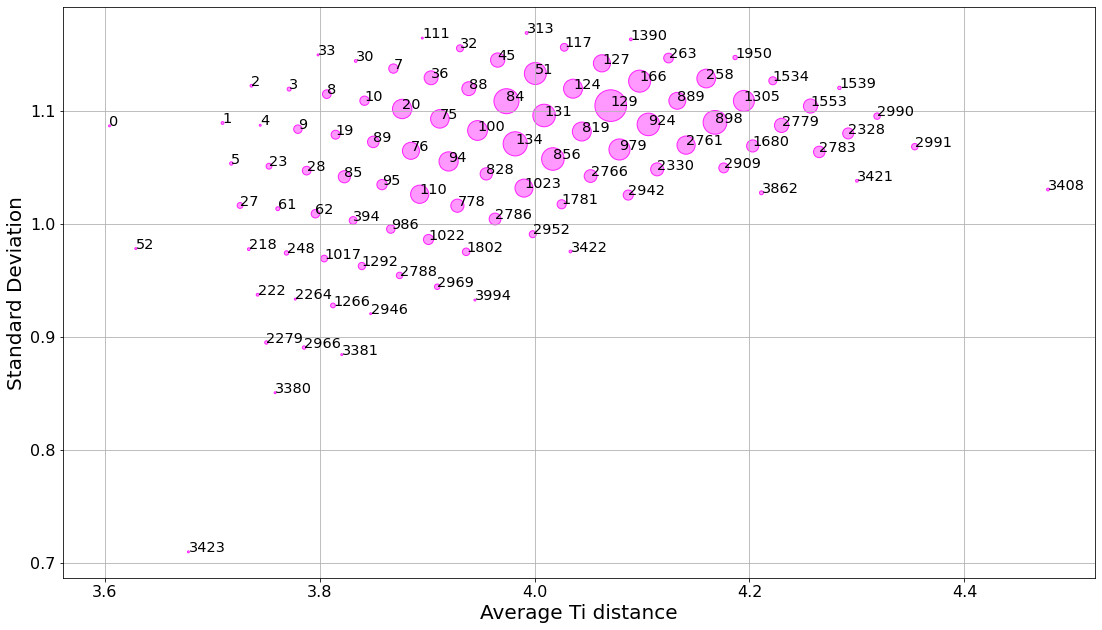

In [69]:
import matplotlib.pyplot as plt

font = {'size'   : 14.5,
       'weight': 'normal'}

plt.rc('font', **font)

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()
ax.scatter(dist_std_unique[:,0], dist_std_unique[:,1],s=dist_std_occ/max(dist_std_occ)*1000, 
           edgecolors='#ff22ff', color='#ff99ff')

label = dist_std_first

ax.set_xlabel('Average Ti distance', fontsize=20)
ax.set_ylabel('Standard Deviation', fontsize=20) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.grid()

for i, txt in enumerate(label):
    ax.annotate(txt, (dist_std_unique[i,0], dist_std_unique[i,1]),)
fig.set_size_inches(18.5, 10.5)

plt.show()

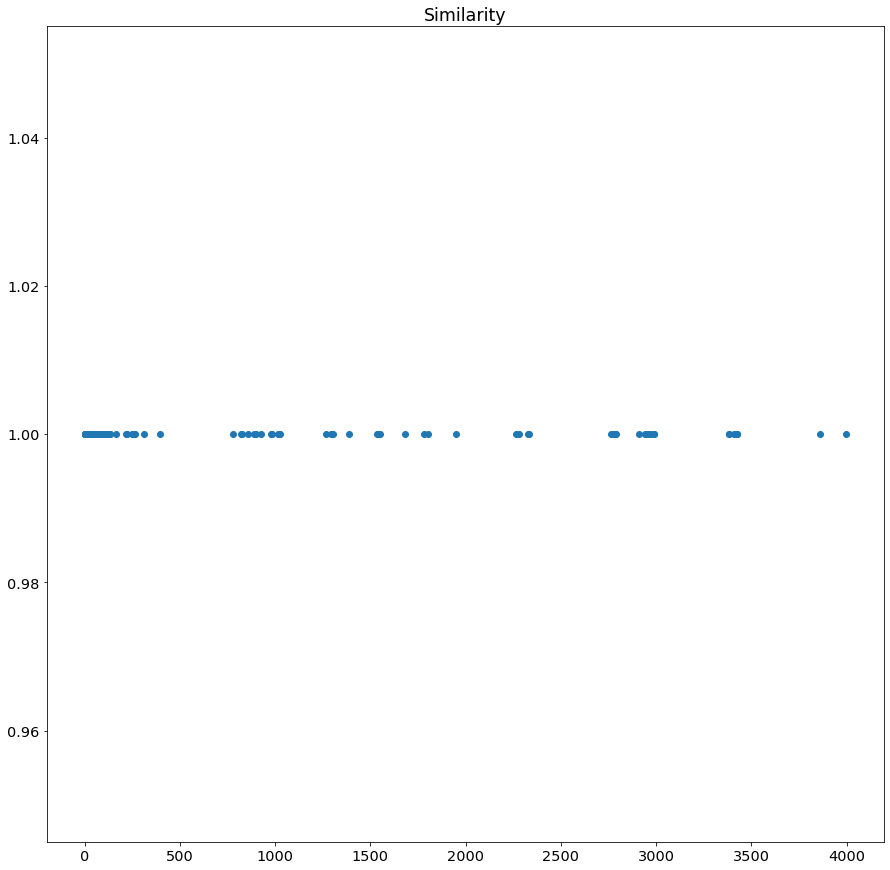

In [70]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

x = np.array(dist_std_first)

y = [1]*len(x)

plt.scatter(x, y)
plt.title('Similarity')
plt.show()

# THE END

### SHRINK test

In [ ]:
struct = cry_gui2pmg('data/classification/ml/optc021')
inp = Crystal_input('data/classification/ml/crystal_input.d12')

with open('data/classification/ml/qsub_input.qsub_SAVE','r') as file:
    qsub_input = file.readlines()

energy = []
for i in range(4,13):

    energy.append(Crystal_output('data/classification/ml/test_shrink/LTS_%s.out'%i).get_final_energy())

In [ ]:
for j,i in enumerate(energy[1:]):
    print(energy[j]-energy[j+1])

# TESTING

## THIS ONE WORKS (it scales better when a large number of shells is included)
It doesn't work for the primitive cell

In [ ]:
max_shell = 2
centered_sph_coords = []
centered_sph_coords_structure = []
neighbours_spatial_dist = []
neighbours_spatial_dist_all = []
import time
time0 = time.time()
for k,structure in enumerate(structures[100:105]):
    print('STRUCTURE',structure)
    time0 = time.time()
    neighbours_spatial_dist = []
    for j in range(structure.num_sites):
        centered_sph_coords = []
        for i in range(structure.num_sites):  
            print(i,j)
            translation_vector = structure.sites[j].distance_and_image(structure.sites[i])[1]
            new_cart_coords = structure.cart_coords[i]+(translation_vector*structure.lattice.abc)
            #print(translation_vector)
            #print(new_cart_coords,structure.cart_coords[i])
            centered_cart_coords = new_cart_coords-structure.cart_coords[j] 
            centered_sph_coords.append(cart2sph(centered_cart_coords[0],centered_cart_coords[1],centered_cart_coords[2]))        
            #print(cart2sph(centered_cart_coords[0],centered_cart_coords[1],centered_cart_coords[2]))
        #centered_sph_coords_all.append(centered_sph_coords)
        centered_sph_coords = np.array(centered_sph_coords)
        #print(centered_sph_coords)

        atoms_shell = []
        for unique in shells:
            atoms_shell.append(np.where(np.round(centered_sph_coords[:,2],5) == np.round(unique,5))[0].tolist())
            
        #print(atoms_shell)
        neighbours_spatial_dist_atom = []
        for shell in range(max_shell+1):
            #a = np.array(centered_sph_coords)[atoms_shell[shell]]
            spatial_distribution = np.argsort(centered_sph_coords[atoms_shell[shell]][:,1]*10 + centered_sph_coords[atoms_shell[shell]][:,0])
            #print(np.array(structure.atomic_numbers)[np.array(atoms_shell[shell])[spatial_distribution]])
            #print(np.array(atoms_shell[shell])[spatial_distribution])
            
            neighbours_spatial_dist_atom.extend((np.array(structure.atomic_numbers)[np.array(atoms_shell[shell])[spatial_distribution]]).tolist())
            #THIS IS THE CONTROL LINE
            #print(centered_sph_coords[np.array(atoms_shell[shell])[spatial_distribution]])
        neighbours_spatial_dist.append(neighbours_spatial_dist_atom)
    neighbours_spatial_dist_all.append(neighbours_spatial_dist)
    print(time.time()-time0)
    #centered_sph_coords_structure = np.array(centered_sph_coords_all)
